# Text Translation with Amazon Bedrock and Evaluation

> *Recommended kernel: **`Data Science 3.0`** in SageMaker Studio*

## Overview

This notebook demonstrates text translation using Amazon Bedrock with quantitative evaluation metrics.

**What you'll learn:**
- Translate text using Bedrock's Converse API
- Evaluate translation quality with industry-standard metrics (BLEU, BERTScore, METEOR, ChrF)
- Compare model performance across real-world datasets

**Use Case:** Multilingual customer support at scale. Enable English-speaking agents to communicate with customers in their preferred language across chat, email, and ticketing systems.

**Approach:** Zero-shot translation using foundation models via the Bedrock Converse API, with systematic evaluation against reference translations from WMT14 dataset.

## Setup

In [ ]:
!pip install sacrebleu bert-score nltk datasets ipywidgets

In [1]:
from sacrebleu.metrics import BLEU
from bert_score import BERTScorer
from nltk.translate.meteor_score import meteor_score
from nltk.translate.chrf_score import sentence_chrf

In [ ]:
import nltk
nltk.download('wordnet')

In [ ]:
import os 
os.environ['HF_TOKEN'] = 'YOUR_TOKEN'

In [2]:
import boto3
from botocore.exceptions import ClientError

client = boto3.client("bedrock-runtime")

## Translation and Evaluation Functions

We define helper functions for:
1. **Translation**: Call Bedrock Converse API with optimized prompts
2. **Data Loading**: Load reference translations from WMT14 dataset
3. **Evaluation**: Calculate BLEU, BERTScore, METEOR, and ChrF metrics
4. **Visualization**: Generate performance charts

In [ ]:
def translate(model_id, text, target_language="Spanish"):
    """
    Translate text using AWS Bedrock Converse API
    
    Args:
        text (str): Text to translate
        target_language (str): Target language for translation
    
    Returns:
        str: Translated text
    """
    
    # Set up messages for translation
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "text": f"Translate the following text to {target_language}:\n\n{text}"
                }
            ]
        }
    ]
    
    system = [
        {
            "text": "You are a professional translator. Provide only the translated text without any additional explanation or commentary. "
            "Think through the translation step by step, keeping in mind that you will be evaluated using BLEU, bertscore, etc."
            "Your translation must be as true as possible to the source text, regarding semantic and literal meanings."
        }
    ]
    
    try:
        # Send the message to the model
        response = client.converse(
            modelId=model_id,
            messages=messages,
            system=system,
            inferenceConfig={
                "maxTokens": 1500, 
                "temperature": 0.3,  # Lower temperature for more consistent translations
                "topP": 0.9
            },
        )
        
        # Extract the translated text
        translated_text = ""
        for content_block in response["output"]["message"]["content"]:
            if "text" in content_block:
                translated_text += content_block["text"]
        
        return translated_text.strip()
        
    except (ClientError, Exception) as e:
        print(f"ERROR: Can't invoke '{model_id}'. Reason: {e}")
        return None

In [6]:
# Load a real translation dataset for evaluation
from datasets import load_dataset

def load_translation_data(language_pair="de", dataset_name="wmt14", split="validation", max_samples=10):
    """
    Load translation dataset for evaluation
    
    Args:
        language_pair (str): Target language (de, fr, es, etc.)
        dataset_name (str): Dataset to use (wmt14, opus_books, etc.)
        split (str): Dataset split (test, validation)
        max_samples (int): Number of samples to load
    
    Returns:
        tuple: (source_texts, reference_translations)
    """
    try:
        # Load WMT14 EN->DE as example
        if dataset_name == "wmt14":
            dataset = load_dataset("wmt14", f"de-en", split=split)
        elif dataset_name == "opus_books":
            dataset = load_dataset("opus_books", f"en-{language_pair}", split="train")
        
        # Extract English and target language texts
        source_texts = []
        reference_translations = []
        
        for i, example in enumerate(dataset):
            if i >= max_samples:
                break
                
            if dataset_name == "wmt14":
                source_texts.append(example['translation']['en'])
                reference_translations.append(example['translation']['de'])
            elif dataset_name == "opus_books":
                source_texts.append(example['translation']['en'])
                reference_translations.append(example['translation'][language_pair])
        
        return source_texts, reference_translations
        
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return [], []

In [7]:
def evaluate_translation(references, translations):
    """
    Evaluate multiple translation pairs and return individual + average scores
    
    Args:
        references (list): List of reference translations
        translations (list): List of model translations
    
    Returns:
        dict: Individual scores per pair + averaged scores
    """
    if len(references) != len(translations):
        raise ValueError("References and translations must have same length")
    
    individual_scores = []
    all_bleu_scores = []
    all_bert_scores = []
    all_meteor_scores = []
    all_chrf_scores = []
    
    # Initialize BERTScorer once for efficiency
    scorer = BERTScorer(model_type='bert-base-uncased', lang='en')
    
    print(f"Evaluating {len(references)} translation pairs...\n")
    
    for i, (reference_text, translated_text) in enumerate(zip(references, translations)):
        print(f"=== Pair {i+1} ===")
        print(f"Reference: {reference_text}")
        print(f"Translation: {translated_text}")
        
        # BLEU Score
        bleu_score = BLEU().corpus_score([translated_text], [[reference_text]]).score / 100
        
        # BERTScore
        P, R, F1 = scorer.score([translated_text], [reference_text])
        bert_f1 = F1.mean().item()
        
        # METEOR Score
        translated_tokens = translated_text.split()
        reference_tokens = [reference_text.split()]
        meteor_result = meteor_score(reference_tokens, translated_tokens)
        
        # ChrF Score
        chrf_result = sentence_chrf(
            reference=reference_text,
            hypothesis=translated_text,
            min_len=1,
            max_len=6,
            beta=3.0
        )
        
        # Store individual scores
        pair_scores = {
            "BLEU": bleu_score,
            "BERTScore_F1": bert_f1,
            "METEOR": meteor_result,
            "ChrF": chrf_result
        }
        individual_scores.append(pair_scores)
        
        # Collect for averaging
        all_bleu_scores.append(bleu_score)
        all_bert_scores.append(bert_f1)
        all_meteor_scores.append(meteor_result)
        all_chrf_scores.append(chrf_result)
        
        print(f"BLEU: {bleu_score:.4f}")
        print(f"BERTScore F1: {bert_f1:.4f}")
        print(f"METEOR: {meteor_result:.4f}")
        print(f"ChrF: {chrf_result:.4f}")
        print("-" * 50)
    
    # Calculate averages
    avg_scores = {
        "BLEU": sum(all_bleu_scores) / len(all_bleu_scores),
        "BERTScore_F1": sum(all_bert_scores) / len(all_bert_scores),
        "METEOR": sum(all_meteor_scores) / len(all_meteor_scores),
        "ChrF": sum(all_chrf_scores) / len(all_chrf_scores)
    }
    
    print("\n=== AVERAGE SCORES ===")
    for metric, score in avg_scores.items():
        print(f"{metric}: {score:.4f}")
    
    return {
        "individual_scores": individual_scores,
        "average_scores": avg_scores,
        "num_pairs": len(references)
    }

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_translation_metrics(results):
    """
    Create visualizations for translation evaluation results
    
    Args:
        results (dict): Results from evaluate_translation function
    """
    individual_scores = results['individual_scores']
    average_scores = results['average_scores']
    num_pairs = results['num_pairs']
    
    # Extract metrics data
    metrics = ['BLEU', 'BERTScore_F1', 'METEOR', 'ChrF']
    pair_numbers = list(range(1, num_pairs + 1))
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Individual scores per pair (line plot)
    for metric in metrics:
        scores = [pair[metric] for pair in individual_scores]
        ax1.plot(pair_numbers, scores, marker='o', label=metric, linewidth=2)
    
    ax1.set_xlabel('Translation Pair')
    ax1.set_ylabel('Score')
    ax1.set_title('Individual Scores per Translation Pair')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(pair_numbers)
    
    # 2. Average scores bar chart
    avg_values = [average_scores[metric] for metric in metrics]
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
    bars = ax2.bar(metrics, avg_values, color=colors, alpha=0.7)
    
    # Add value labels on bars
    for bar, value in zip(bars, avg_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax2.set_ylabel('Average Score')
    ax2.set_title('Average Performance Across All Metrics')
    ax2.set_ylim(0, max(avg_values) * 1.15)
    
    # 3. Radar/Spider chart showing metric balance
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    ax3.remove()  # Remove the subplot
    ax3 = fig.add_subplot(2, 2, 3, projection='polar')
    
    # Plot each translation pair
    colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    for i, pair_scores in enumerate(individual_scores):
        values = [pair_scores[metric] for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax3.plot(angles, values, 'o-', linewidth=2, 
                label=f'Pair {i+1}', color=colors_radar[i % len(colors_radar)])
        ax3.fill(angles, values, alpha=0.1, color=colors_radar[i % len(colors_radar)])
    
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(metrics)
    ax3.set_title('Translation Performance Radar Chart', pad=20)
    ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax3.set_ylim(0, 1)
    
    # 4. Box plot showing score distribution
    score_data = []
    for metric in metrics:
        scores = [pair[metric] for pair in individual_scores]
        score_data.append(scores)
    
    box_plot = ax4.boxplot(score_data, labels=metrics, patch_artist=True)
    
    # Color the boxes
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax4.set_ylabel('Score')
    ax4.set_title('Score Distribution per Metric')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== SUMMARY STATISTICS ===")
    for metric in metrics:
        scores = [pair[metric] for pair in individual_scores]
        print(f"{metric}:")
        print(f"  Mean: {np.mean(scores):.4f}")
        print(f"  Std:  {np.std(scores):.4f}")
        print(f"  Min:  {np.min(scores):.4f}")
        print(f"  Max:  {np.max(scores):.4f}")
        print()

## Load Test Data

We use the WMT14 English-German translation dataset for evaluation. This provides professional reference translations to benchmark model performance.

In [ ]:
# Load sample data
print("Loading translation dataset...")
english_texts, german_references = load_translation_data(language_pair="de", max_samples=10)

for i, (en, de) in enumerate(zip(english_texts, german_references)):
    print(f"\nSample {i+1}:")
    print(f"English: {en}")
    print(f"German Reference: {de}")
    print("-" * 50)

In [ ]:
MODEL_IDS = ["openai.gpt-oss-20b-1:0", "openai.gpt-oss-120b-1:0"]

In [15]:
preds = [translate(MODEL_IDS[0], text, "German") for text in english_texts]

In [ ]:
results = evaluate_translation(german_references, preds)
results

## Run Translation and Evaluation

**Key Points:**
- System prompt instructs the model to act as a professional translator
- Temperature set to 0.3 for consistent, deterministic translations
- Evaluation uses multiple metrics to assess different aspects of translation quality:
  - **BLEU**: N-gram overlap with reference (0-1, higher is better)
  - **BERTScore**: Semantic similarity using contextual embeddings (0-1, higher is better)
  - **METEOR**: Considers synonyms and paraphrasing (0-1, higher is better)
  - **ChrF**: Character-level F-score, robust to morphological variations (0-1, higher is better)

/var/folders/zd/mxghr1k55_n_3xrkm07wk_5c0000gq/T/ipykernel_10164/3711405407.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(score_data, labels=metrics, patch_artist=True)


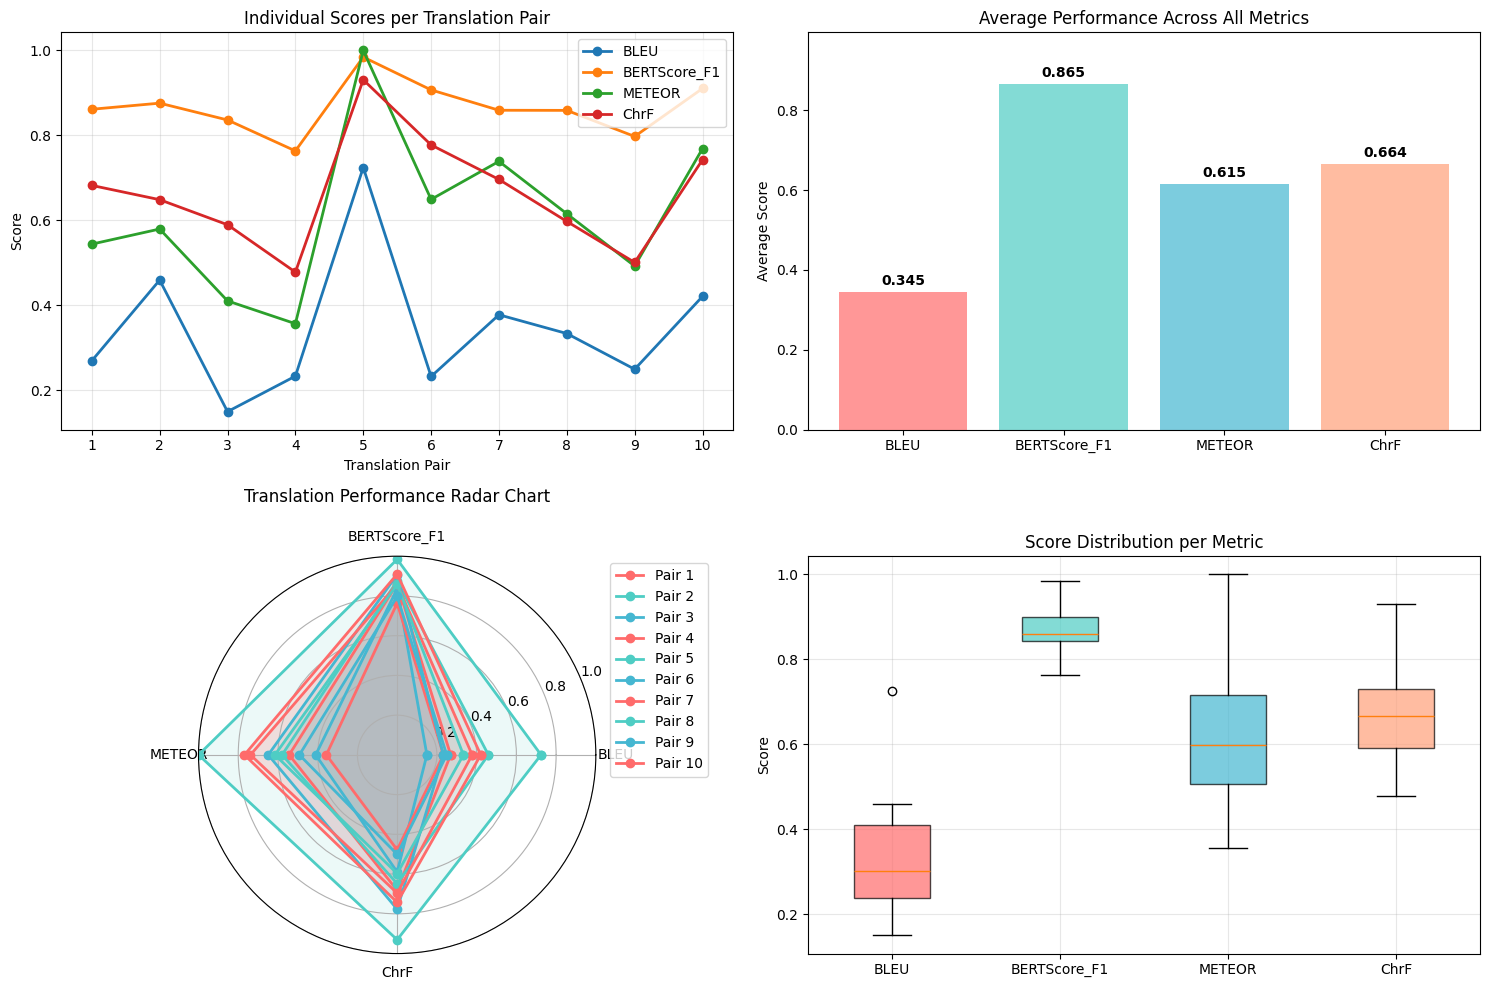


=== SUMMARY STATISTICS ===
BLEU:
  Mean: 0.3449
  Std:  0.1556
  Min:  0.1496
  Max:  0.7242

BERTScore_F1:
  Mean: 0.8652
  Std:  0.0583
  Min:  0.7632
  Max:  0.9841

METEOR:
  Mean: 0.6154
  Std:  0.1784
  Min:  0.3566
  Max:  0.9998

ChrF:
  Mean: 0.6642
  Std:  0.1277
  Min:  0.4779
  Max:  0.9306



In [13]:
# gpt-oss-20b
visualize_translation_metrics(results)

In [ ]:
preds = [translate(MODEL_IDS[1], text, "German") for text in english_texts]
results = evaluate_translation(german_references, preds)
results

/var/folders/zd/mxghr1k55_n_3xrkm07wk_5c0000gq/T/ipykernel_10164/3711405407.py:78: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax4.boxplot(score_data, labels=metrics, patch_artist=True)


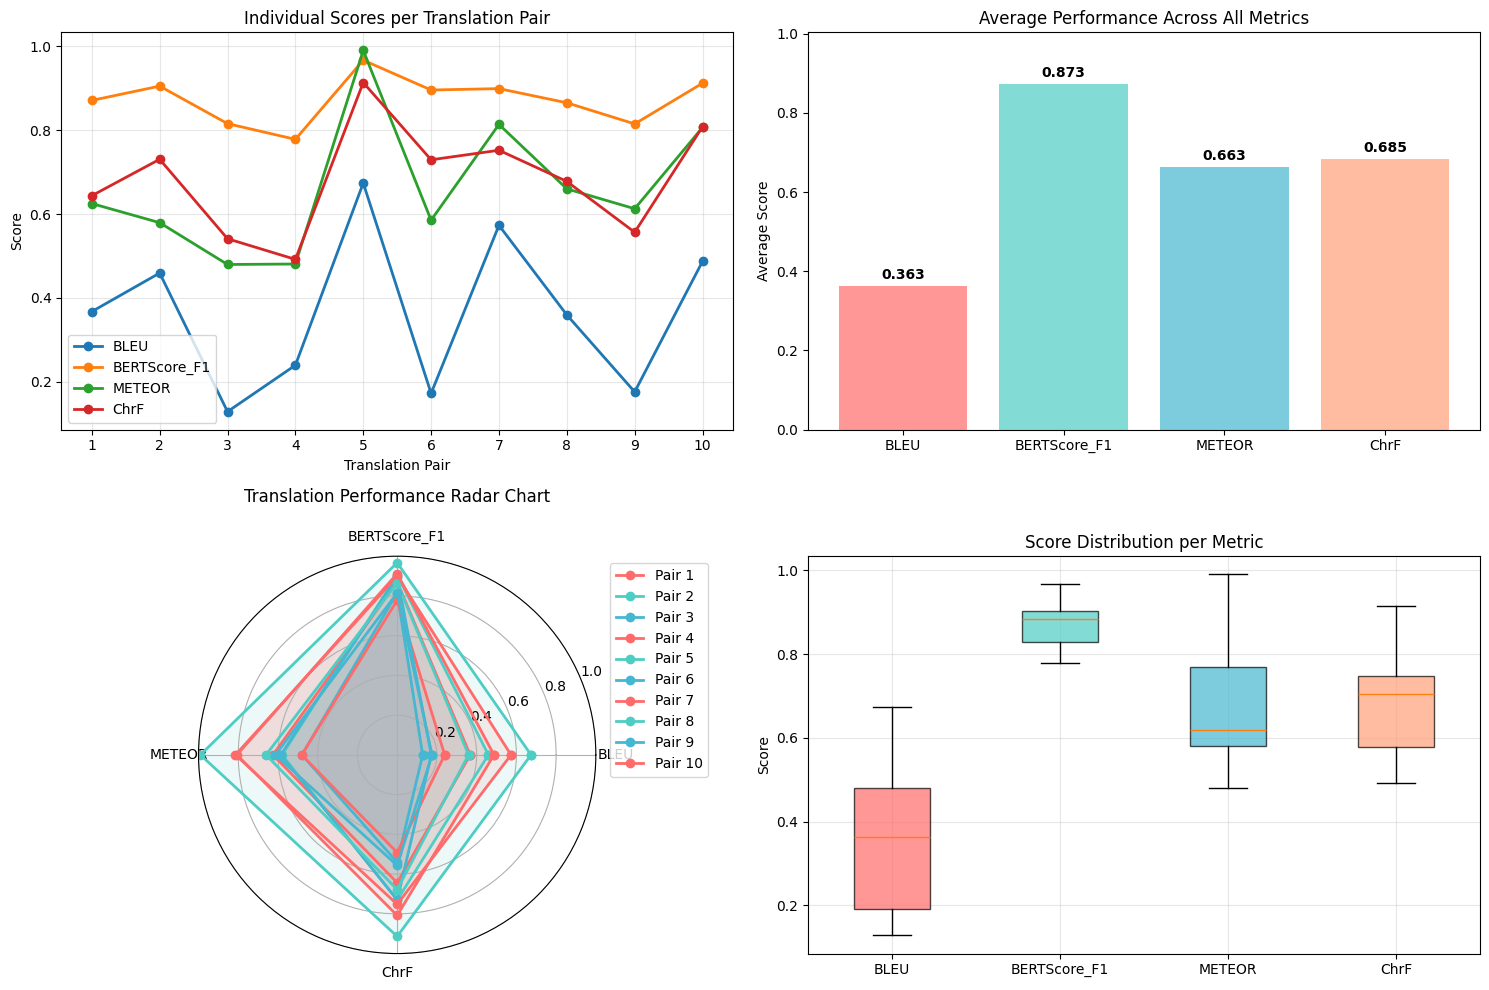


=== SUMMARY STATISTICS ===
BLEU:
  Mean: 0.3635
  Std:  0.1754
  Min:  0.1284
  Max:  0.6739

BERTScore_F1:
  Mean: 0.8726
  Std:  0.0532
  Min:  0.7783
  Max:  0.9672

METEOR:
  Mean: 0.6634
  Std:  0.1532
  Min:  0.4796
  Max:  0.9906

ChrF:
  Mean: 0.6845
  Std:  0.1235
  Min:  0.4918
  Max:  0.9139



In [17]:
# gpt-oss-120b
visualize_translation_metrics(results)

## Conclusion
You have now experimented with using `boto3` SDK which provides a vanilla exposure to Amazon Bedrock API. Using this API you have seen the use case of translating text to target language

### Take aways
- Adapt this notebook to experiment with different models available through Amazon Bedrock such as Anthropic Claude and AI21 Labs Jurassic models.
- Change the prompts to your specific usecase and evaluate the output of different models.
- Play with the token length to understand the latency and responsiveness of the service.
- Apply different prompt engineering principles to get better outputs.

## Thank You